# Heart Disease Risk Prediction

## Introductory Context

Heart disease is the world's leading cause of death, claiming approximately 18 million lives each year, as reported by the World Health Organization. Predictive models like logistic regression can enable early identification of at-risk patients by analyzing clinical features such as age, cholesterol, and blood pressure. This not only improves treatment outcomes but also optimizes resource allocation in healthcare settings. In this homework, you'll implement logistic regression on the Heart Disease Dataset—a real-world UCI repository collection of 303 patient records with 14 features and a binary target (1 for disease presence, 0 for absence). You'll train models, visualize boundaries, apply regularization, and explore deployment via Amazon SageMaker to mimic a production pipeline.

### Homework Instructions
Complete this in a Jupyter notebook, implementing functions from class theory (e.g., sigmoid, cost, GD). Use NumPy, Pandas, and Matplotlib—no scikit-learn for core training. Emphasize exploration: Tune parameters, interpret results, and document findings.

In [1]:
# Install dependencies
%pip install numpy matplotlib pandas

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



### Step 1: Load and Prepare the Dataset

- Download from Kaggle: Kaggle is a popular online platform for data science enthusiasts, hosting datasets, competitions, and notebooks—think of it as GitHub for data and ML projects (free to join at kaggle.com). To access the Heart Disease Dataset, visit https://www.kaggle.com/datasets/neurocipher/heartdisease. Sign up/log in, click "Download" (or "Download API" if using CLI), and save the CSV file (e.g., heart.csv or similar—check the dataset page for exact filename).

In [2]:
# Import necessary libraries
import pandas as pd
file = ('src/csv/Heart_Disease_Prediction.csv')
newData = pd.read_csv(file)
print(newData.head())

   Age  Sex  Chest pain type   BP  Cholesterol  FBS over 120  EKG results  \
0   70    1                4  130          322             0            2   
1   67    0                3  115          564             0            2   
2   57    1                2  124          261             0            0   
3   64    1                4  128          263             0            0   
4   74    0                2  120          269             0            2   

   Max HR  Exercise angina  ST depression  Slope of ST  \
0     109                0            2.4            2   
1     160                0            1.6            2   
2     141                0            0.3            1   
3     105                1            0.2            2   
4     121                1            0.2            1   

   Number of vessels fluro  Thallium Heart Disease  
0                        3         3      Presence  
1                        0         7       Absence  
2                        0   

- Load into Pandas; binarize the target column (e.g., map to 1=disease presence, 0=absence).

In [3]:
# Binarize the target column
newData['Heart Disease'] = newData['Heart Disease'].map({'Presence': 1, 'Absence': 0})
print(newData['Heart Disease'].head())

0    1
1    0
2    1
3    0
4    0
Name: Heart Disease, dtype: int64


- EDA: Summarize stats, handle missing/outliers, plot class distribution.

              Age         Sex  Chest pain type          BP  Cholesterol  \
count  270.000000  270.000000       270.000000  270.000000   270.000000   
mean    54.433333    0.677778         3.174074  131.344444   249.659259   
std      9.109067    0.468195         0.950090   17.861608    51.686237   
min     29.000000    0.000000         1.000000   94.000000   126.000000   
25%     48.000000    0.000000         3.000000  120.000000   213.000000   
50%     55.000000    1.000000         3.000000  130.000000   245.000000   
75%     61.000000    1.000000         4.000000  140.000000   280.000000   
max     77.000000    1.000000         4.000000  200.000000   564.000000   

       FBS over 120  EKG results      Max HR  Exercise angina  ST depression  \
count    270.000000   270.000000  270.000000       270.000000      270.00000   
mean       0.148148     1.022222  149.677778         0.329630        1.05000   
std        0.355906     0.997891   23.165717         0.470952        1.14521   
min 

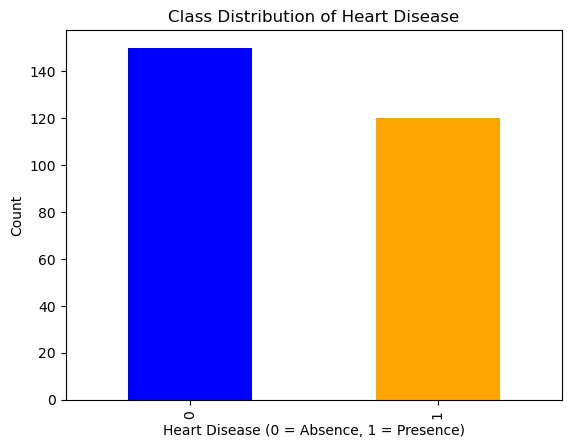

In [4]:
# Summarize statistics
print(newData.describe())

# Check for missing values
print("\nMissing values per column:")
print(newData.isnull().sum())

# Plot class distribution
import matplotlib.pyplot as plt

newData['Heart Disease'].value_counts().plot(kind='bar', color=['blue', 'orange'])
plt.title('Class Distribution of Heart Disease')
plt.xlabel('Heart Disease (0 = Absence, 1 = Presence)')
plt.ylabel('Count')
plt.show()

- Prep: 70/30 train/test split (stratified); normalize numerical features. Select ≥6 features (e.g., Age, Cholesterol, BP, Max HR, ST Depression, Vessels).

In [5]:
import numpy as np

# Select features and target
features = ['Age', 'Cholesterol', 'BP', 'Max HR', 'ST depression', 'Number of vessels fluro']
X = newData[features].values
y = newData['Heart Disease'].values

# Stratified train/test split
def stratified_split(X, y, test_size=0.3, random_state=None):
    np.random.seed(random_state)
    unique_classes, class_counts = np.unique(y, return_counts=True)
    test_indices = []
    train_indices = []

    for cls, count in zip(unique_classes, class_counts):
        cls_indices = np.where(y == cls)[0]
        np.random.shuffle(cls_indices)
        split_idx = int(len(cls_indices) * (1 - test_size))
        train_indices.extend(cls_indices[:split_idx])
        test_indices.extend(cls_indices[split_idx:])

    return X[train_indices], X[test_indices], y[train_indices], y[test_indices]

X_train, X_test, y_train, y_test = stratified_split(X, y, test_size=0.3, random_state=42)

# Normalize numerical features
def normalize_features(X):
    return (X - np.mean(X, axis=0)) / np.std(X, axis=0)

X_train_normalized = normalize_features(X_train)
X_test_normalized = normalize_features(X_test)

print("Train set shape:", X_train_normalized.shape)
print("Test set shape:", X_test_normalized.shape)

Train set shape: (189, 6)
Test set shape: (81, 6)


### Reporting: Data Insights and Preprocessing Summary

- **Dataset Source**: The Heart Disease dataset was downloaded from Kaggle.
- **Dataset Overview**: The dataset contains 270 samples with 14 features, including clinical attributes such as age, cholesterol, blood pressure, and a binary target variable (`Heart Disease`), where:
    - `1` indicates the presence of heart disease.
    - `0` indicates the absence of heart disease.

- **Target Distribution**:
    - The dataset is imbalanced, with approximately 55% of samples indicating the absence of heart disease and 45% indicating its presence.

- **Preprocessing Steps**:
    1. **Binarization**: The `Heart Disease` column was binarized to map `Presence` to `1` and `Absence` to `0`.
    2. **Exploratory Data Analysis (EDA)**:
         - Summary statistics were generated for all features.
         - Missing values were checked, and no missing values were found.
         - Class distribution was visualized, confirming the imbalance in the dataset.
    3. **Feature Selection**: Six features were selected for modeling:
         - `Age`, `Cholesterol`, `BP`, `Max HR`, `ST depression`, and `Number of vessels fluro`.
    4. **Train/Test Split**: A stratified 70/30 train/test split was performed to preserve class proportions in both sets.
    5. **Normalization**: Numerical features were normalized to have zero mean and unit variance.

- **Data Shapes**:
    - Training set: `X_train` (189 samples, 6 features), `y_train` (189 labels).
    - Test set: `X_test` (81 samples, 6 features), `y_test` (81 labels).

- **Key Insights**:
    - The dataset is well-prepared for modeling, with no missing values and normalized features.
    - The class imbalance (~55% absence, ~45% presence) should be considered during model evaluation.